## **Week 5: Building our CNN**
### José Manuel López, Alex Martín, Marcos V. Conde

In [1]:
import tensorflow as tf
import warnings
import os
import matplotlib.pyplot as plt

from tensorflow.python.util import deprecation
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D

In [2]:
DATA_DIR_SMALL = "./datasets/MIT_small_train_{}"
DATA_DIR_BIG = "./datasets/MIT_split"
IMG_SIZE = 64
BATCH_SIZE = 64
RANDOM_SEED = 42
CLASSES = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']

In [3]:
# Disable Warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# VRAM broke without this
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.config.experimental_run_functions_eagerly(True)

try:
    # print model to see if it's compatible with Mixed Precision
    print(device_lib.list_local_devices()[3].physical_device_desc)
    # Change to TF16 mixed precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
except:
    pass

print(gpus[0])
print(tf.__version__)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.7.1


In [4]:
def get_dataset(path, aug):
    print("Loading: {}".format(path))
    if not aug:
        train_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)

        train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

        test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
        
        return train_loader, test_loader
        
    else:

        train_datagen = ImageDataGenerator(rescale=1./255, featurewise_center = False, samplewise_center = False,
                                           featurewise_std_normalization = False, samplewise_std_normalization = False,
                                           rotation_range = 0.2, width_shift_range = 15, height_shift_range = 15, shear_range = 0.2,
                                           zoom_range = 0.2, fill_mode = "nearest", horizontal_flip = True
                                            )
        test_datagen = ImageDataGenerator(rescale=1./255)

        train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

        test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
        
        return train_loader, test_loader



In [5]:
train_small, test_small = get_dataset(DATA_DIR_SMALL.format(1), aug = True)
train_big, test_big = get_dataset(DATA_DIR_BIG, aug = True)


examples = enumerate(train_big)
batch_idx, (example_data, example_targets) = next(examples)
print("Data Shape: {}".format(example_data.shape))

Loading: ./datasets/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Loading: ./datasets/MIT_split
Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Data Shape: (64, 64, 64, 3)


In [6]:
def build_model(n_conv, kernel_size, conv, n_dense, dense, opt):
    #create model
    model = Sequential()
    #add model layers
    for i in range(n_conv):
        model.add(Conv2D(conv, kernel_size=kernel_size, activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,3)))

    model.add(GlobalAveragePooling2D())

    for i in range(n_dense):
        model.add(Dense(dense, activation="relu"))

    model.add(Dense(len(CLASSES), activation="softmax"))

    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=["accuracy"])

    return model



def plot_loss_accuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
    
    fig.suptitle(title, fontsize=16)

    # Plot history: CrossEntropy
    ax1.plot(history.history['loss'], label='CrossEntropy (training data)')
    ax1.plot(history.history['val_loss'], label='CrossEntropy (validation data)')
    ax1.set_title('Loss Function: Cross Entropy')
    ax1.set(xlabel='Epoch', ylabel='Loss Value')
    ax1.legend(loc="upper left")

    # Plot history: Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
    ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy Value')
    ax2.legend(loc="upper left")

    plt.show()

## Checking Convolutional Layers

In [13]:
N_CONV  = 1
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024
model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 9s 326ms/step - loss: 2.0605 - accuracy: 0.1607 - val_loss: 2.0122 - val_accuracy: 0.2109
Epoch 2/50
29/29 [==============================] - 8s 284ms/step - loss: 1.9754 - accuracy: 0.2251 - val_loss: 1.8843 - val_accuracy: 0.2617
Epoch 3/50
29/29 [==============================] - 8s 290ms/step - loss: 1.8766 - accuracy: 0.2785 - val_loss: 1.7795 - val_accuracy: 0.3151
Epoch 4/50
29/29 [==============================] - 8s 265ms/step - loss: 1.8089 - accuracy: 0.2950 - val_loss: 1.7116 - val_accuracy: 0.3672
Epoch 5/50
29/29 [==============================] - 9s 298ms/step - loss: 1.7359 - accuracy: 0.3319 - val_loss: 1.6282 - val_accuracy: 0.3789
Epoch 6/50
29/29 [==============================] - 9s 329ms/step - loss: 1.6934 - accuracy: 0.3720 - val_loss: 1.6506 - val_accuracy: 0.3737
Epoch 7/50
29/29 [==============================] - 7s 258ms/step - loss: 1.6517 - accuracy: 0.3715 - val_loss: 1.5715 - val_accuracy: 0.4323
Epoch 

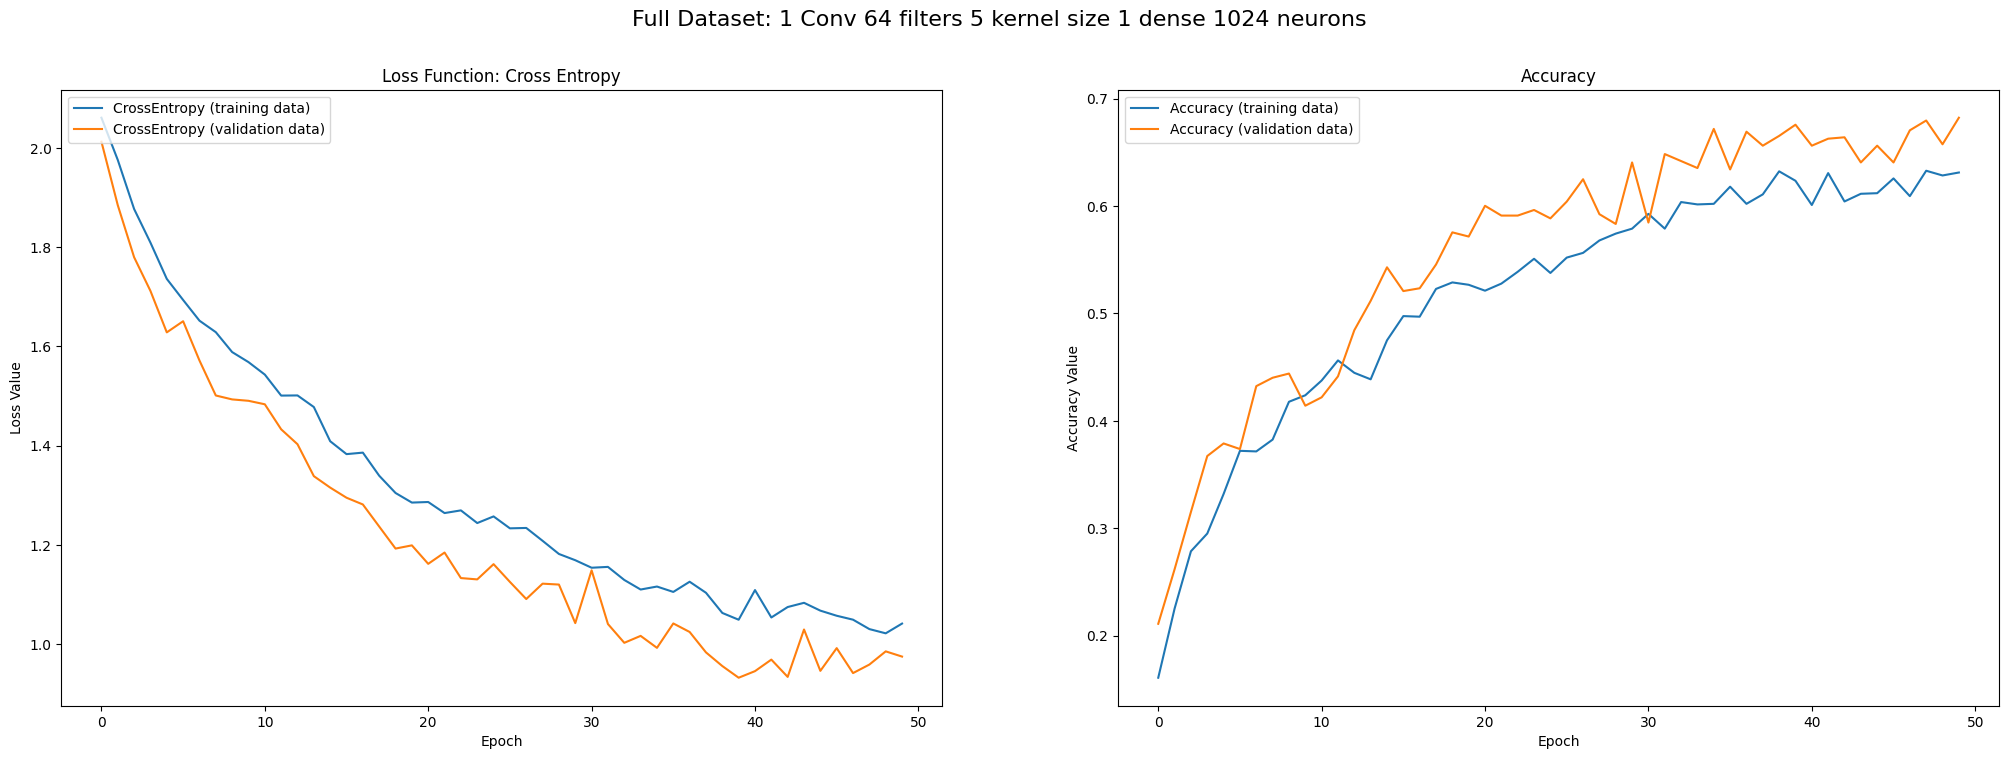

In [14]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))


In [15]:
N_CONV  = 2
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024
model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 8s 267ms/step - loss: 2.0285 - accuracy: 0.1728 - val_loss: 1.9116 - val_accuracy: 0.2513
Epoch 2/50
29/29 [==============================] - 9s 308ms/step - loss: 1.8742 - accuracy: 0.2796 - val_loss: 1.7379 - val_accuracy: 0.3281
Epoch 3/50
29/29 [==============================] - 8s 290ms/step - loss: 1.7777 - accuracy: 0.3269 - val_loss: 1.6968 - val_accuracy: 0.3346
Epoch 4/50
29/29 [==============================] - 9s 303ms/step - loss: 1.6944 - accuracy: 0.3544 - val_loss: 1.6552 - val_accuracy: 0.3581
Epoch 5/50
29/29 [==============================] - 9s 299ms/step - loss: 1.6586 - accuracy: 0.3660 - val_loss: 1.5252 - val_accuracy: 0.4453
Epoch 6/50
29/29 [==============================] - 8s 275ms/step - loss: 1.5870 - accuracy: 0.4095 - val_loss: 1.4637 - val_accuracy: 0.4297
Epoch 7/50
29/29 [==============================] - 8s 288ms/step - loss: 1.5212 - accuracy: 0.4403 - val_loss: 1.4560 - val_accuracy: 0.4414
Epoch 

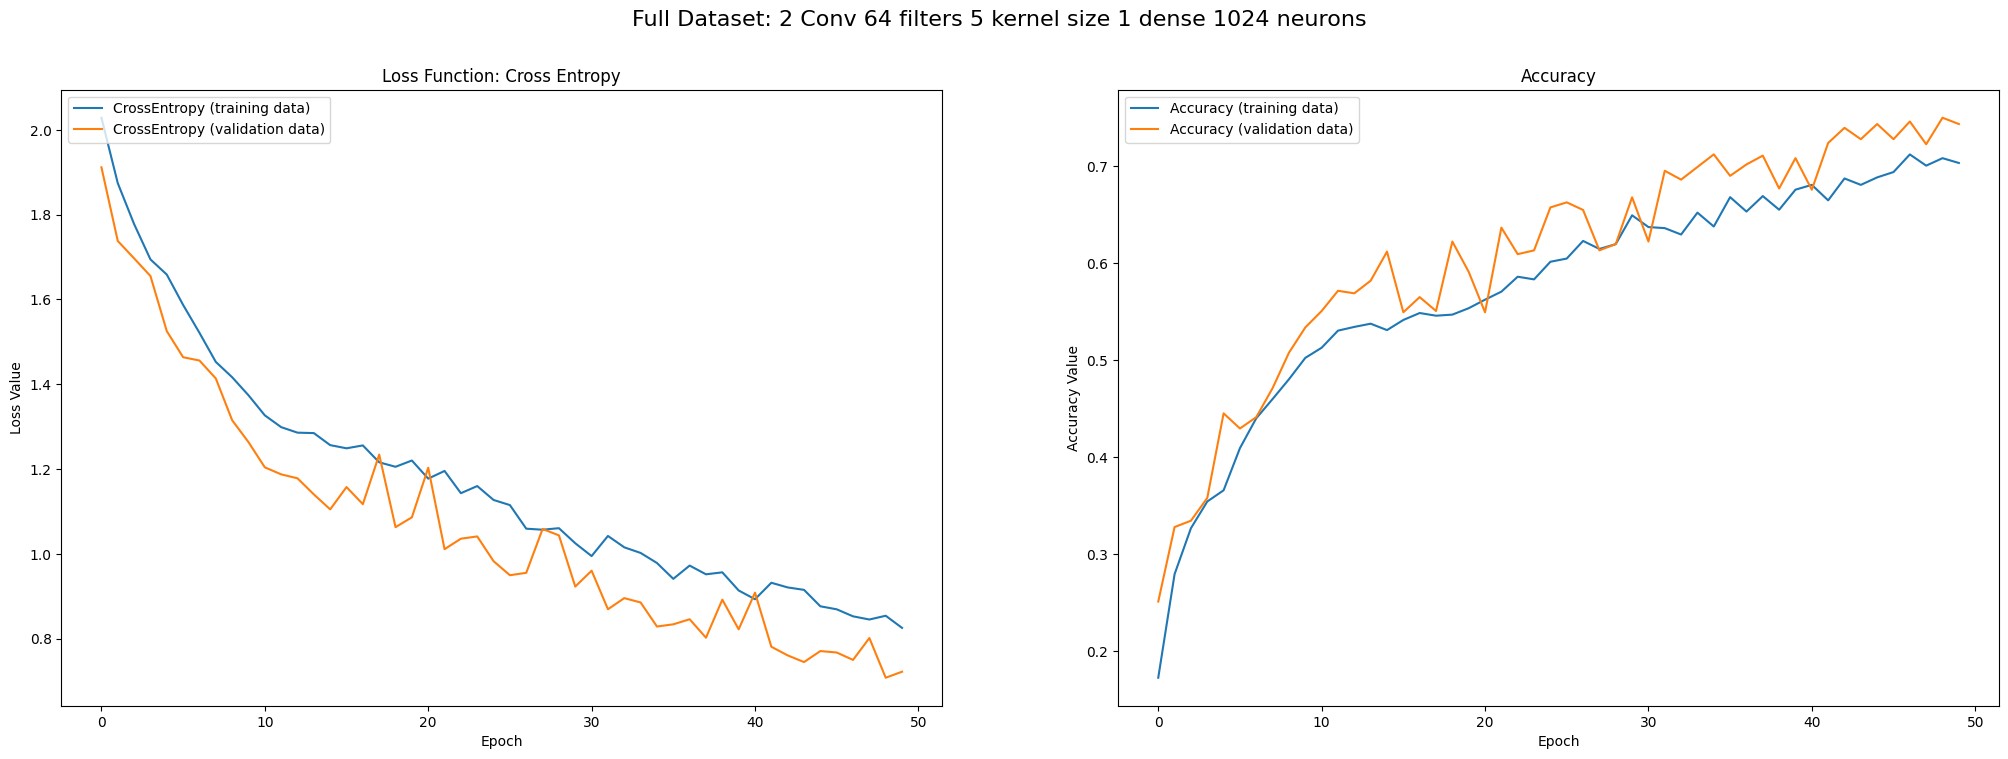

Train Accuracy: 0.6991  Train Loss: 0.8351
Test Accuracy: 0.7348  Test Loss: 0.7371


In [16]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [18]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024
model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 9s 311ms/step - loss: 2.0169 - accuracy: 0.1811 - val_loss: 1.8815 - val_accuracy: 0.2565
Epoch 2/50
29/29 [==============================] - 10s 334ms/step - loss: 1.8642 - accuracy: 0.2867 - val_loss: 1.7744 - val_accuracy: 0.3268
Epoch 3/50
29/29 [==============================] - 9s 316ms/step - loss: 1.8348 - accuracy: 0.2746 - val_loss: 1.7010 - val_accuracy: 0.3229
Epoch 4/50
29/29 [==============================] - 8s 275ms/step - loss: 1.7302 - accuracy: 0.3313 - val_loss: 1.6490 - val_accuracy: 0.3555
Epoch 5/50
29/29 [==============================] - 8s 287ms/step - loss: 1.6749 - accuracy: 0.3621 - val_loss: 1.5573 - val_accuracy: 0.4128
Epoch 6/50
29/29 [==============================] - 8s 295ms/step - loss: 1.6316 - accuracy: 0.3819 - val_loss: 1.5686 - val_accuracy: 0.3984
Epoch 7/50
29/29 [==============================] - 9s 305ms/step - loss: 1.5458 - accuracy: 0.4007 - val_loss: 1.3501 - val_accuracy: 0.4661
Epoch

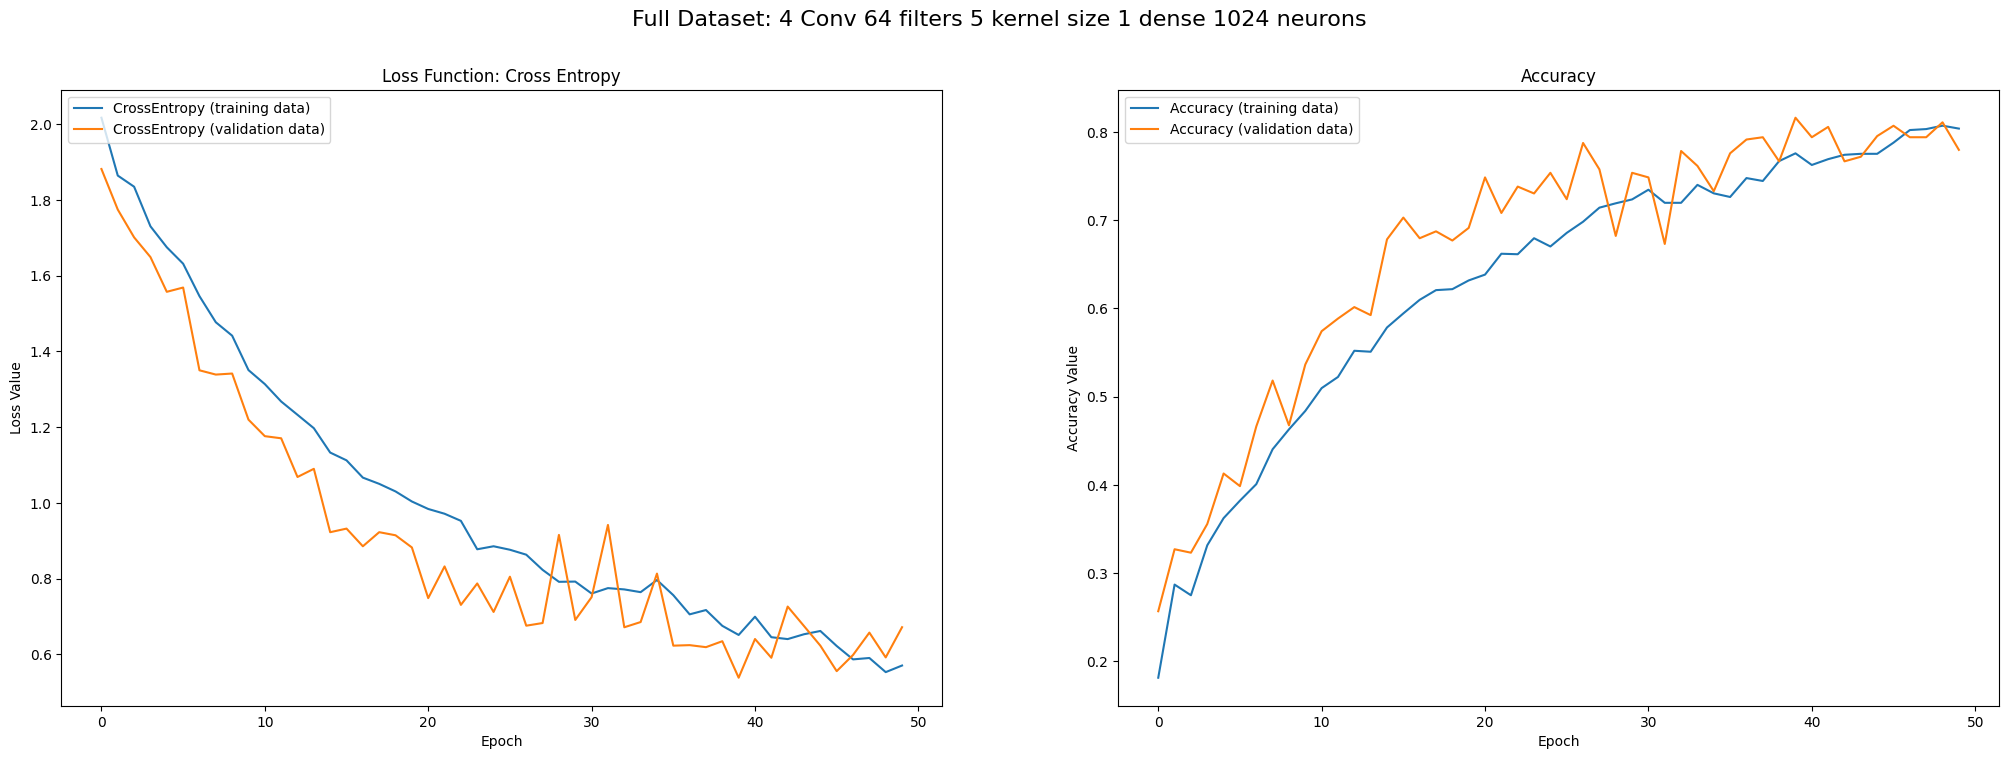

Train Accuracy: 0.8070  Train Loss: 0.5739
Test Accuracy: 0.7782  Test Loss: 0.6730


In [19]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [20]:
N_CONV  = 8
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024
model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 10s 339ms/step - loss: 2.0764 - accuracy: 0.1491 - val_loss: 2.0721 - val_accuracy: 0.1484
Epoch 2/50
29/29 [==============================] - 8s 289ms/step - loss: 2.0408 - accuracy: 0.1657 - val_loss: 1.9904 - val_accuracy: 0.1693
Epoch 3/50
29/29 [==============================] - 8s 268ms/step - loss: 2.0119 - accuracy: 0.1855 - val_loss: 1.9385 - val_accuracy: 0.2383
Epoch 4/50
29/29 [==============================] - 9s 319ms/step - loss: 1.9081 - accuracy: 0.2449 - val_loss: 1.7019 - val_accuracy: 0.3203
Epoch 5/50
29/29 [==============================] - 9s 295ms/step - loss: 1.8302 - accuracy: 0.2988 - val_loss: 1.6589 - val_accuracy: 0.3555
Epoch 6/50
29/29 [==============================] - 8s 278ms/step - loss: 1.7237 - accuracy: 0.3434 - val_loss: 1.7589 - val_accuracy: 0.3281
Epoch 7/50
29/29 [==============================] - 10s 351ms/step - loss: 1.6457 - accuracy: 0.3649 - val_loss: 1.4855 - val_accuracy: 0.3984
Epoc

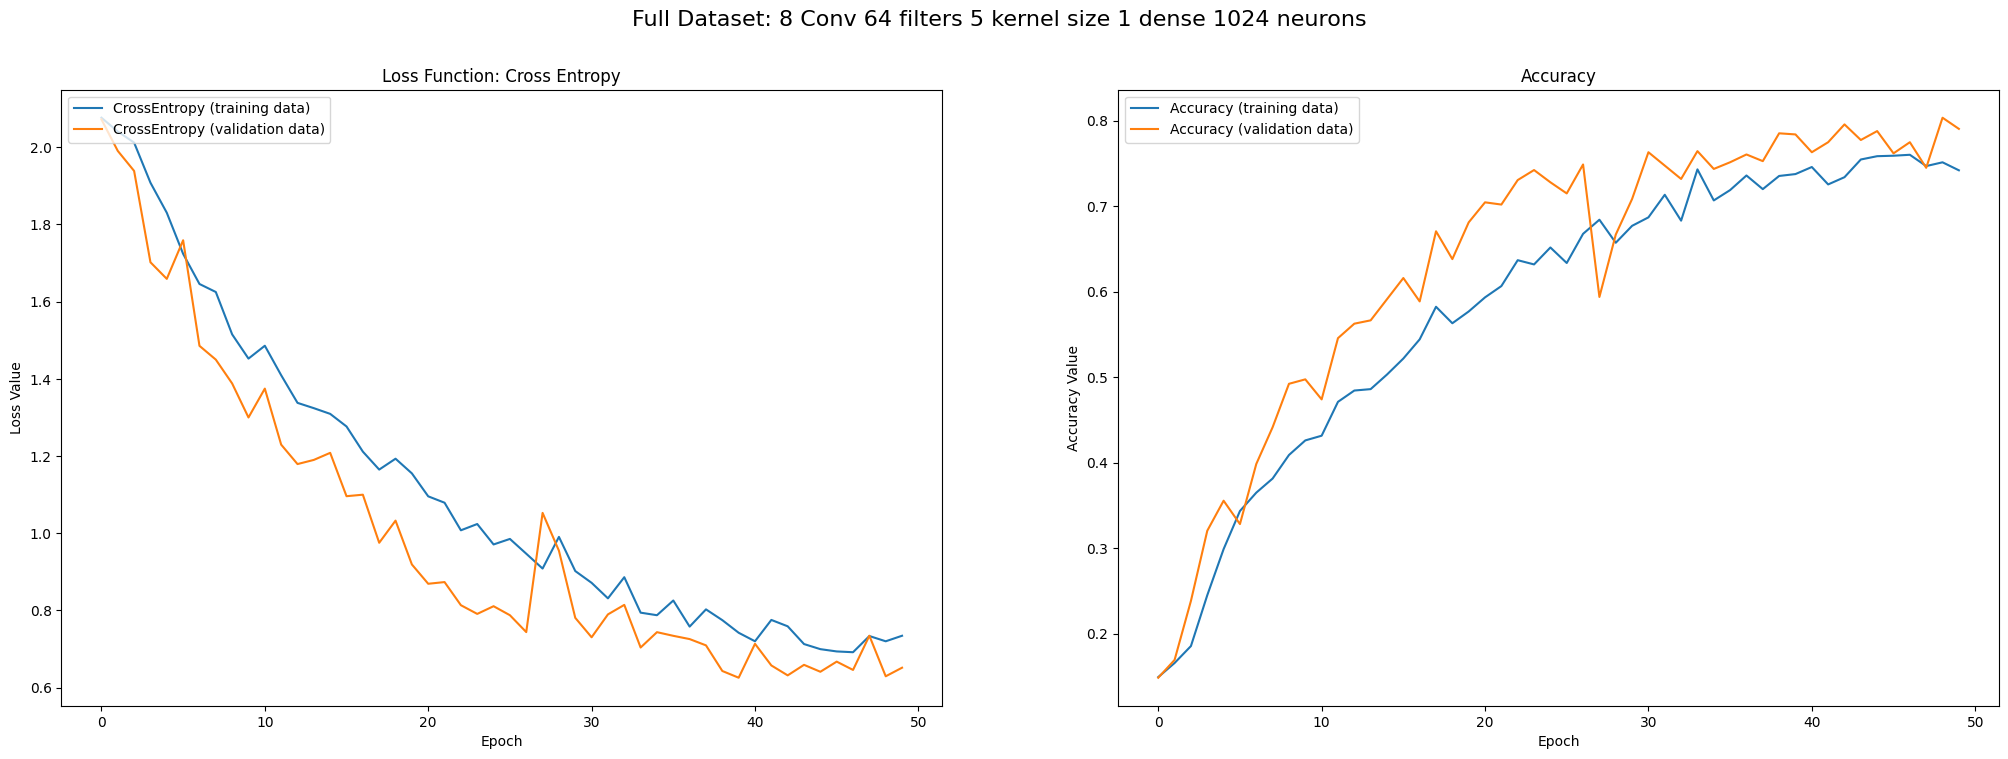

Train Accuracy: 0.7554  Train Loss: 0.7045
Test Accuracy: 0.7918  Test Loss: 0.6473


In [21]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

## Checking Dense Layers

In [22]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 2
DENSE = 1024
model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 10s 340ms/step - loss: 2.0499 - accuracy: 0.1607 - val_loss: 1.9548 - val_accuracy: 0.2409
Epoch 2/50
29/29 [==============================] - 9s 306ms/step - loss: 1.9127 - accuracy: 0.2312 - val_loss: 1.7376 - val_accuracy: 0.3099
Epoch 3/50
29/29 [==============================] - 9s 301ms/step - loss: 1.8712 - accuracy: 0.2614 - val_loss: 1.8240 - val_accuracy: 0.2747
Epoch 4/50
29/29 [==============================] - 9s 327ms/step - loss: 1.7643 - accuracy: 0.3165 - val_loss: 1.6318 - val_accuracy: 0.3828
Epoch 5/50
29/29 [==============================] - 8s 268ms/step - loss: 1.7214 - accuracy: 0.3214 - val_loss: 1.6313 - val_accuracy: 0.3659
Epoch 6/50
29/29 [==============================] - 9s 315ms/step - loss: 1.6234 - accuracy: 0.3841 - val_loss: 1.6580 - val_accuracy: 0.3451
Epoch 7/50
29/29 [==============================] - 9s 297ms/step - loss: 1.5187 - accuracy: 0.3946 - val_loss: 1.3650 - val_accuracy: 0.4701
Epoch

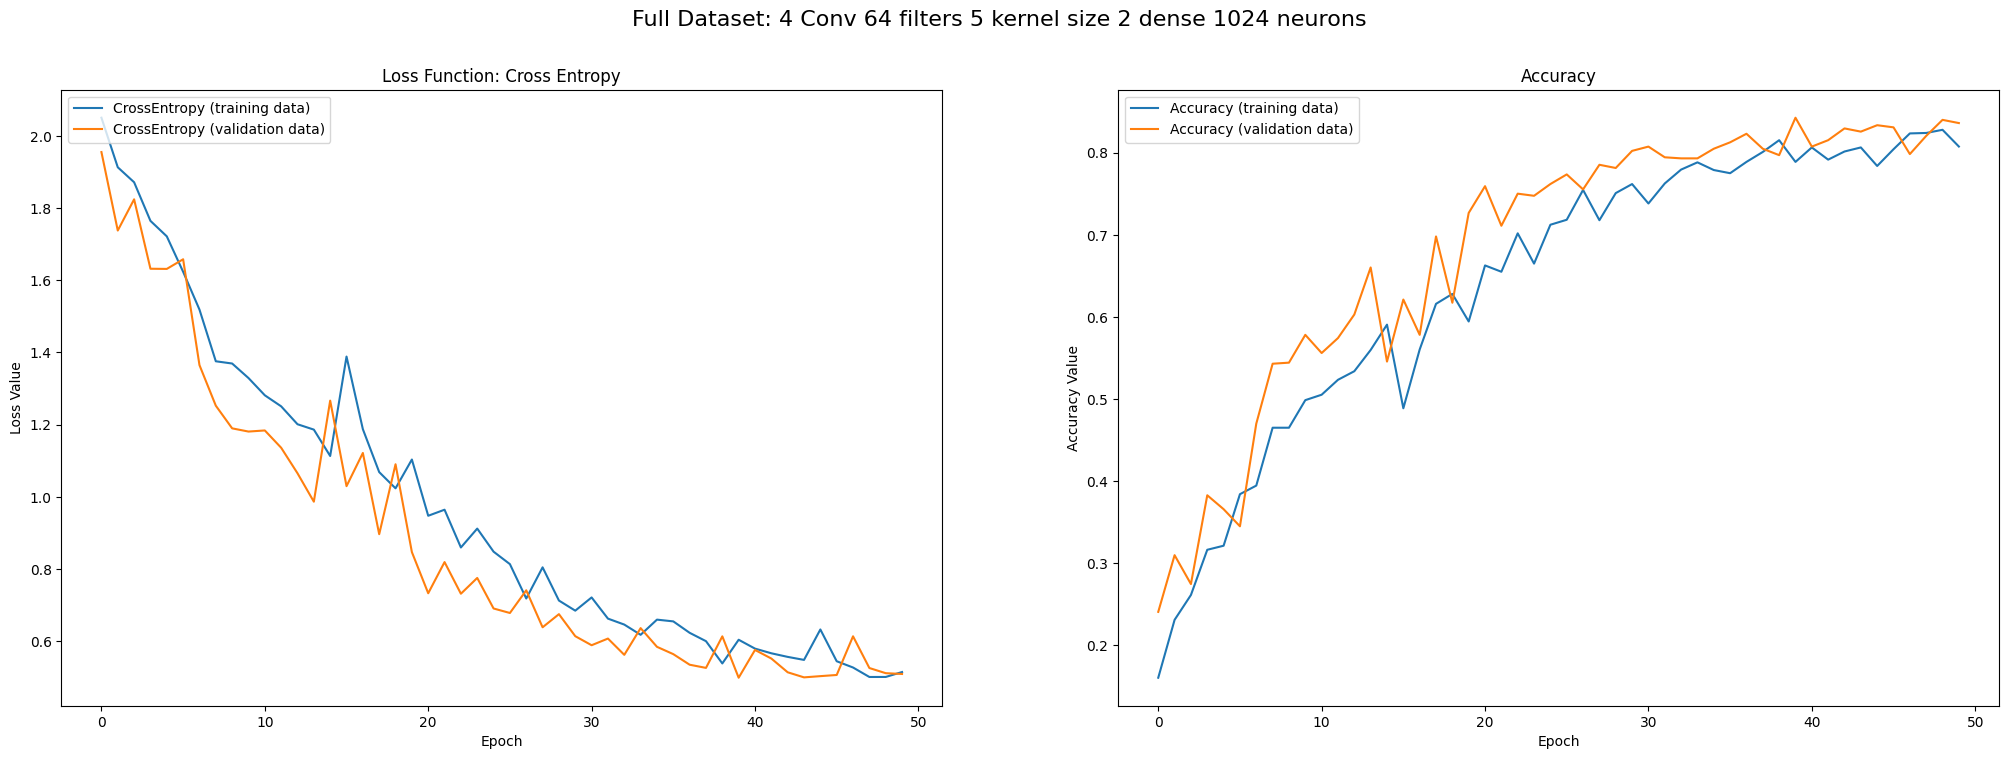

Train Accuracy: 0.8028  Train Loss: 0.5473
Test Accuracy: 0.8364  Test Loss: 0.5110


In [23]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [26]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 4
DENSE = 1024
model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 9s 303ms/step - loss: 2.0242 - accuracy: 0.1712 - val_loss: 1.8531 - val_accuracy: 0.2396
Epoch 2/50
29/29 [==============================] - 8s 258ms/step - loss: 1.9133 - accuracy: 0.2361 - val_loss: 1.8586 - val_accuracy: 0.2422
Epoch 3/50
29/29 [==============================] - 8s 278ms/step - loss: 1.9158 - accuracy: 0.2433 - val_loss: 1.8917 - val_accuracy: 0.2161
Epoch 4/50
29/29 [==============================] - 8s 288ms/step - loss: 1.9407 - accuracy: 0.2152 - val_loss: 1.7942 - val_accuracy: 0.2396
Epoch 5/50
29/29 [==============================] - 9s 312ms/step - loss: 1.8234 - accuracy: 0.2895 - val_loss: 1.6794 - val_accuracy: 0.3542
Epoch 6/50
29/29 [==============================] - 8s 282ms/step - loss: 1.7430 - accuracy: 0.3319 - val_loss: 1.5782 - val_accuracy: 0.3724
Epoch 7/50
29/29 [==============================] - 8s 292ms/step - loss: 1.5724 - accuracy: 0.3726 - val_loss: 1.4550 - val_accuracy: 0.4180
Epoch 

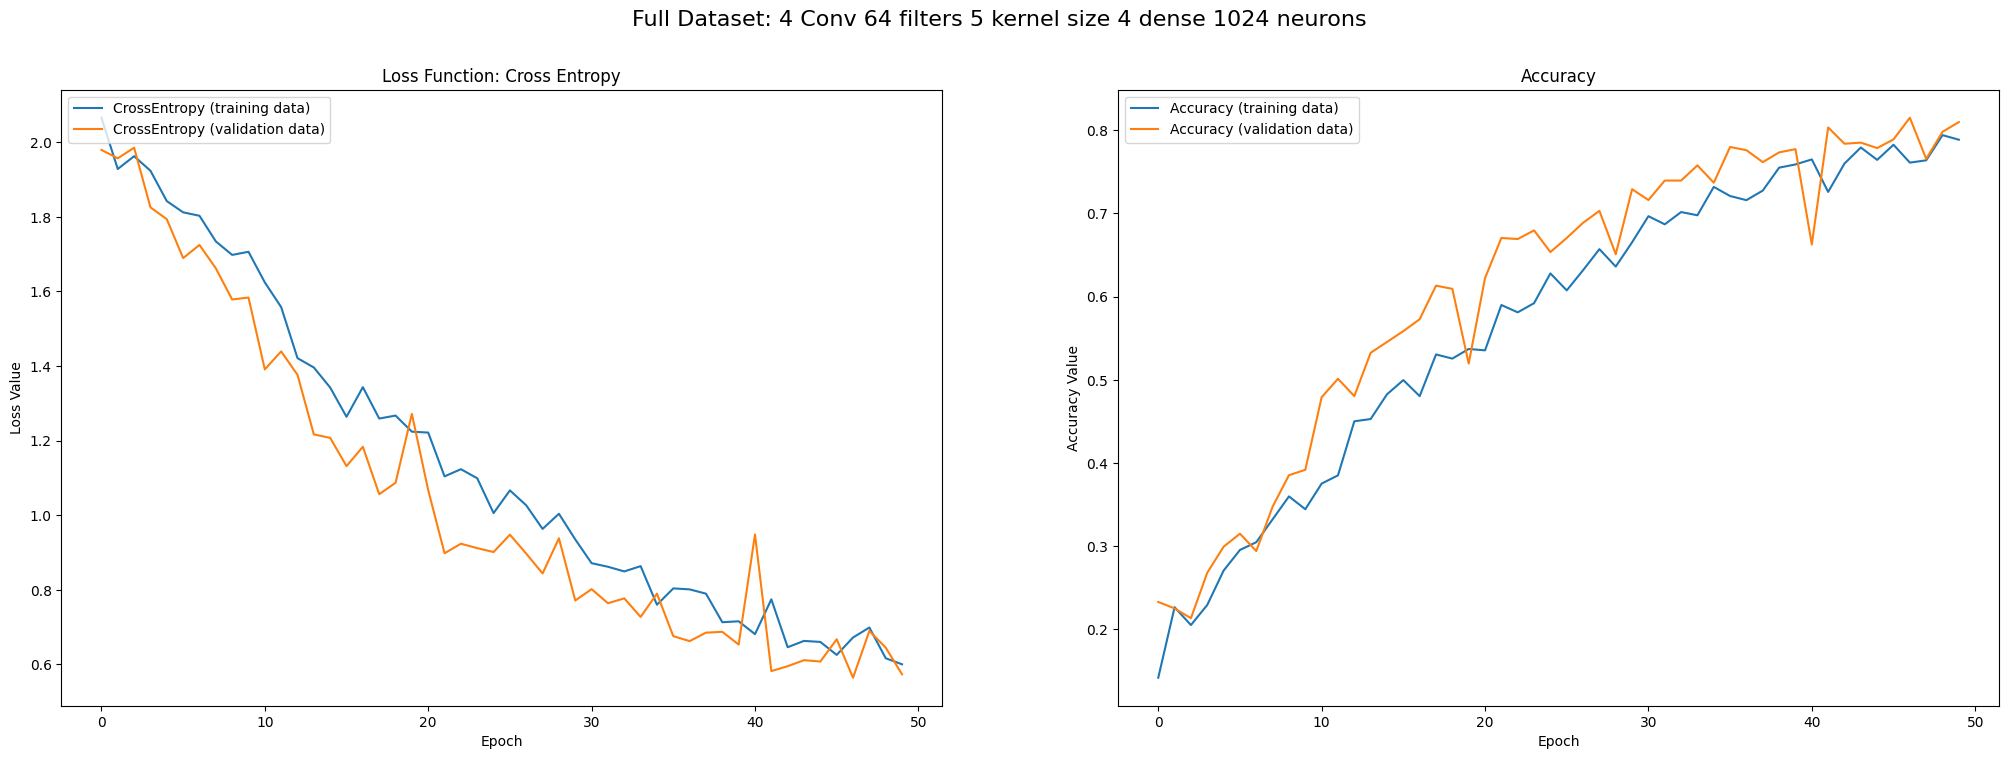

Train Accuracy: 0.8134  Train Loss: 0.5664
Test Accuracy: 0.8104  Test Loss: 0.5726


In [ ]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))